## Phase 2: Flow Control & Logic


##### Conditional Branching (Decision Making)


In [ ]:
from langgraph.graph import StateGraph, END

# A Decider Node
def decide_next_step(state: GraphState) -> str:
    if "math" in state["user_input"].lower():
        print("--- Decision: Math keyword detected. Going to Calculator.")
        return "calculator_tool"
    elif "factual" in state["user_input"].lower():
        print("--- Decision: Factual keyword detected. Going to Search.")
        return "search_tool"
    else:
        print("--- Decision: Chat/General query. Going to LLM Chat.")
        return "llm_chat"

# ... assuming nodes 'calculator_tool', 'search_tool', and 'llm_chat' are defined ...

workflow.add_node("decider", decide_next_step)

# workflow.add_conditional_edges(source, condition_function, mapping)

# Use add_conditional_edges
workflow.add_conditional_edges(
    # Source node that makes the decision
    "decider", 
    # The function that is the decider (it MUST return the name of the next node)
    decide_next_step, 
    # Optional: Map the string output to the target node name
    {
        "calculator_tool": "calculator_tool",
        "search_tool": "search_tool",
        "llm_chat": "llm_chat",
    }
)


##### Tools & Functions Integration

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode

# 1. Define the tool
search_tool = TavilySearchResults(max_results=3)
tools = [search_tool]

# 2. Create the special ToolNode
# This node takes a tool call from the LLM, executes it, and updates the state.
tool_node = ToolNode(tools)

# 3. Add to the graph
# workflow.add_node("search_tool_executor", tool_node) 
# (Assuming we have a node that generates the tool call)

this is the core of agentic workflows!
Without tools, agents are just fancy chatbots — but with tools, they become intelligent assistants that can act in the real world.

So yes, we’ll go step by step, starting from the simplest possible tool, and gradually move to:
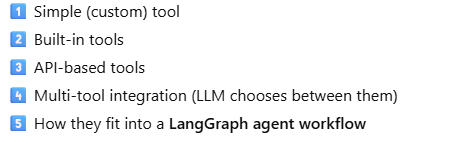

> 🌱 Phase 1 — The Simplest Tool: Custom Python Function

In [2]:
# without any APIs, just a pure Python tool, 
# so you can see how tool calling logic works under the hood.

from langchain.tools import tool
from langchain_ollama import ChatOllama
from langgraph.prebuilt import ToolNode

# 1️⃣ Define the tool
@tool
def add_numbers(a: int, b: int) -> int:
    """Adds two numbers and returns the sum."""
    return a + b

# 2️⃣ Create LLM
llm = ChatOllama(
    model="gpt-oss:120b-cloud"
)

# 3️⃣ Bind the tools
llm_with_tools = llm.bind_tools([add_numbers])

# 4️⃣ Create ToolNode
tool_node = ToolNode([add_numbers])

# 5️⃣ Direct test (optional)
print(add_numbers.invoke({"a": 3, "b": 5}))  # → 8


8


##### ⚙️ Goal , We’ll build this tiny graph:

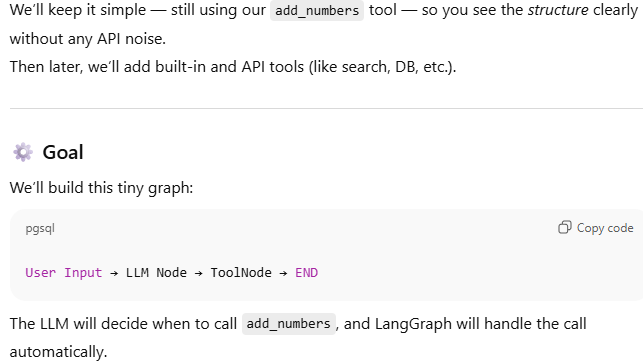
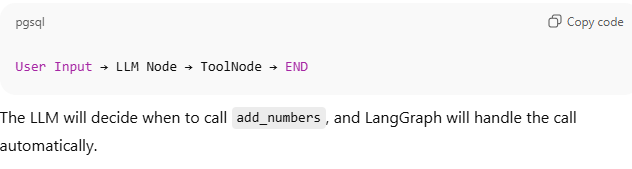

In [3]:
# 1️⃣ Imports
from langchain.tools import tool
from langchain_ollama import ChatOllama
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from typing import TypedDict
from langchain_core.messages import AIMessage
# 2️⃣ Define Graph State
class GraphState(TypedDict):
    user_input: str
    messages: list

# 3️⃣ Define the tool
@tool
def add_numbers(a: int, b: int) -> int:
    """Adds two numbers and returns the sum."""
    return a + b

# 4️⃣ Define LLM and bind tools
llm = ChatOllama(
    model="gpt-oss:120b-cloud"
)
llm_with_tools = llm.bind_tools([add_numbers])

# 5️⃣ Define LLM node
def call_model(state: GraphState):
    # Step 1: prepare messages
    user_msg = state["user_input"]

    # Step 2: ask model
    response = llm_with_tools.invoke(user_msg)

    # Step 3: store messages for tool node
    return {"messages": [response]}  # ✅ send as list

# 6️⃣ Define Tool Node
tool_node = ToolNode([add_numbers])

# 7️⃣ Define workflow
workflow = StateGraph(GraphState)
workflow.add_node("llm", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge("llm", "tools")
workflow.add_edge("tools", END)
workflow.set_entry_point("llm")

app = workflow.compile()

# 8️⃣ Run
result = app.invoke({"user_input": "Add 3 and 7 using add_numbers tool"}) # type: ignore
print(result)


{'user_input': 'Add 3 and 7 using add_numbers tool', 'messages': [ToolMessage(content='10', name='add_numbers', tool_call_id='3ad3554f-ef8b-4704-80b4-77638ac60b44')]}


>  2️⃣ Built-in tools

In [4]:
# 1️⃣ Imports
from langchain_community.tools import DuckDuckGoSearchResults
from langchain_ollama import ChatOllama
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from typing import TypedDict

# 2️⃣ Define State
class GraphState(TypedDict):
    user_input: str
    messages: list

# 3️⃣ Define Tool
search_tool = DuckDuckGoSearchResults()

# 4️⃣ LLM + Bind
llm = ChatOllama(
    model="gpt-oss:120b-cloud"
)
llm_with_tools = llm.bind_tools([search_tool])

# 5️⃣ LLM Node
def call_model(state: GraphState):
    response = llm_with_tools.invoke(state["user_input"])
    return {"messages": [response]}

# 6️⃣ Tool Node
tool_node = ToolNode([search_tool])

# 7️⃣ Graph
workflow = StateGraph(GraphState)
workflow.add_node("llm", call_model)
workflow.add_node("tools", tool_node)
workflow.add_edge("llm", "tools")
workflow.add_edge("tools", END)
workflow.set_entry_point("llm")
app = workflow.compile()

# 8️⃣ Run
result = app.invoke({"user_input": "Search for today's latest news about Donald trump and what he said about his 3rd terms run for presidental election."}) # type: ignore
print(result)




{'user_input': "Search for today's latest news about Donald trump and what he said about his 3rd terms run for presidental election.", 'messages': [ToolMessage(content='snippet: 1 day ago · President Donald Trump appeared to acknowledge Wednesday that he cannot run for a third term , after previously declining to rule out the possibility., title: Trump says \'it\'s pretty clear\' he can\'t run for 3rd term ..., link: https://abcnews.go.com/Politics/trump-pretty-clear-run-3rd-term/story?id=126968713, snippet: 1 day ago · His comments came after House Speaker Mike Johnson stated it would be impossible for Trump to keep serving as president. Johnson explained that the 22nd Amendment prevents a third term and ..., title: Trump says ‘it’s too bad’ he can’t run for a third term, link: https://www.pbs.org/newshour/politics/trump-says-its-too-bad-he-cant-run-for-a-third-term, snippet: 1 day ago · President Donald Trump has said it is “pretty clear” the US Constitution does not permit him to ru

In [ ]:
pip install -U ddgs

> 3️⃣ API-based tools — the most real-world and powerful type 💪

In [7]:
# 1️⃣ Imports
from langchain.tools import tool
from langchain_ollama import ChatOllama
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from typing import TypedDict
import requests

# 2️⃣ Define Graph State
class GraphState(TypedDict):
    user_input: str
    messages: list

# 3️⃣ Define API Tool
@tool
def get_weather(city: str) -> str:
    """Fetches current temperature for a given city using Open-Meteo API."""
    try:
        # Get city coordinates
        geo_url = f"https://geocoding-api.open-meteo.com/v1/search?name={city}"
        geo = requests.get(geo_url).json()

        if not geo.get("results"):
            return f"City '{city}' not found."

        lat = geo["results"][0]["latitude"]
        lon = geo["results"][0]["longitude"]

        # Get current weather
        weather_url = f"https://api.open-meteo.com/v1/forecast?latitude={lat}&longitude={lon}&current_weather=true"
        weather = requests.get(weather_url).json()
        temp = weather["current_weather"]["temperature"]

        return f"The current temperature in {city} is {temp}°C."
    except Exception as e:
        return f"Error: {e}"

# 4️⃣ Define LLM and bind the tool
llm = ChatOllama(
    model="gpt-oss:120b-cloud"
)
llm_with_tools = llm.bind_tools([get_weather])

# 5️⃣ Define LLM Node
def call_model(state: GraphState):
    response = llm_with_tools.invoke(state["user_input"])
    return {"messages": [response]}

# 6️⃣ Define Tool Node
tool_node = ToolNode([get_weather])

# 7️⃣ Build Graph
workflow = StateGraph(GraphState)
workflow.add_node("llm", call_model)
workflow.add_node("tools", tool_node)
workflow.add_edge("llm", "tools")
workflow.add_edge("tools", END)
workflow.set_entry_point("llm")

app = workflow.compile()

# 8️⃣ Run
result = app.invoke({"user_input": "Check the weather in Delhi"}) # type: ignore
print(result)


{'user_input': 'Check the weather in Delhi', 'messages': [ToolMessage(content='The current temperature in Delhi is 21.0°C.', name='get_weather', tool_call_id='8115ccd4-0d2d-4d5d-87b6-bf4f3540fce2')]}


> 4️⃣: Multi-Tool Integration -> (LLM automatically chooses the right tool)

In [6]:
# 1️⃣ Imports
from langchain.tools import tool
from langchain_ollama import ChatOllama
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from typing import TypedDict
import requests
from datetime import datetime
import pytz

# 2️⃣ Define Graph State
class GraphState(TypedDict):
    user_input: str
    messages: list

# 3️⃣ Define Tools
@tool
def get_weather(city: str) -> str:
    """Fetches current temperature for a given city using Open-Meteo API."""
    try:
        geo = requests.get(f"https://geocoding-api.open-meteo.com/v1/search?name={city}").json()
        if not geo.get("results"):
            return f"City '{city}' not found."
        lat, lon = geo["results"][0]["latitude"], geo["results"][0]["longitude"]
        weather = requests.get(f"https://api.open-meteo.com/v1/forecast?latitude={lat}&longitude={lon}&current_weather=true").json()
        return f"The current temperature in {city} is {weather['current_weather']['temperature']}°C."
    except Exception as e:
        return f"Error: {e}"

@tool
def get_time(city: str) -> str:
    """Returns the current local time for a given city."""
    try:
        geo = requests.get(f"https://geocoding-api.open-meteo.com/v1/search?name={city}").json()
        if not geo.get("results"):
            return f"City '{city}' not found."
        timezone = geo["results"][0]["timezone"]
        local_time = datetime.now(pytz.timezone(timezone)).strftime("%Y-%m-%d %H:%M:%S")
        return f"The current local time in {city} is {local_time}."
    except Exception as e:
        return f"Error: {e}"

# 4️⃣ Define LLM and bind both tools
llm = ChatOllama(
    model="gpt-oss:120b-cloud"
)
llm_with_tools = llm.bind_tools([get_weather, get_time])

# 5️⃣ Define LLM node
def call_model(state: GraphState):
    response = llm_with_tools.invoke(state["user_input"])
    return {"messages": [response]}

# 6️⃣ Define Tool Node
tool_node = ToolNode([get_weather, get_time])

# 7️⃣ Build Graph
workflow = StateGraph(GraphState)
workflow.add_node("llm", call_model)
workflow.add_node("tools", tool_node)
workflow.add_edge("llm", "tools")
workflow.add_edge("tools", END)
workflow.set_entry_point("llm")

app = workflow.compile()

# 8️⃣ Run examples
print("\n🧭 Asking about weather:")
result1 = app.invoke({"user_input": "What's the weather in Delhi right now?"}) # type: ignore
print(result1)

print("\n⏰ Asking about time:")
result2 = app.invoke({"user_input": "What's the current time in Tokyo?"}) # type: ignore
print(result2)



🧭 Asking about weather:
{'user_input': "What's the weather in Delhi right now?", 'messages': [ToolMessage(content='The current temperature in Delhi is 21.2°C.', name='get_weather', tool_call_id='868e2c4f-0cba-48f8-a91b-cb014b929ac8')]}

⏰ Asking about time:
{'user_input': "What's the current time in Tokyo?", 'messages': [ToolMessage(content='The current local time in Tokyo is 2025-10-31 03:06:10.', name='get_time', tool_call_id='e90b3008-1fe7-4026-a0d0-4dc24f6da247')]}


> Create multi-step reasoning flow: LLM → Decider → Tool → LLM

In [ ]:
# Re-using the tool_node and a decision logic function:

# 1. Decision function checks if LLM requested a tool
def route_to_tool_or_end(state: GraphState) -> str:
    # Simplified logic: if the state has a 'tool_call' key, go to the tool node
    if state.get("tool_call"):
        return "tool_node_executor"
    else:
        return END

# Add nodes and edges..
workflow.add_node("llm_agent", llm_node_with_tools) # LLM that can decide to call a tool
workflow.add_node("tool_node_executor", tool_node) # Tool executor

# Sequential edge to start the decision after the LLM runs
workflow.add_edge("llm_agent", "decide_next_step") 

# Conditional edge for the loop
workflow.add_conditional_edges(
    "decide_next_step", 
    route_to_tool_or_end, 
    {"tool_node_executor": "tool_node_executor", END: END}
)

# Edge back to the LLM (THE LOOP)
workflow.add_edge("tool_node_executor", "llm_agent") 


> Loops & Iteration

In [ ]:
MAX_RETRIES = 3

def retry_decider(state: GraphState) -> str:
    retries = state.get("retry_count", 0)
    output_is_valid = state.get("is_valid", False)

    if output_is_valid or retries >= MAX_RETRIES:
        print("--- Loop Exit: Valid output or max retries reached.")
        return END
    else:
        print("--- Loop Back: Invalid output, retrying LLM node.")
        return "llm_generation_node"

# ... assume 'llm_generation_node' and a 'validation_node' exist ...

# Edge from the validation step to the conditional decider
workflow.add_edge("validation_node", "retry_decider") 

# Conditional edge routes back to the generator or to END
workflow.add_conditional_edges(
    "retry_decider", 
    retry_decider, 
    {
        "llm_generation_node": "llm_generation_node", 
        END: END
    }
)


> 🧠 The Concept: “Reflect & Act” Loop (LLM → Decider → Tool → LLM)

In [ ]:
# 🧩 Step-by-Step Implementation (Concept + Code Skeleton)

# 1️⃣ Define the Graph State
class GraphState(TypedDict):
    messages: list
    tool_call: dict | None


# 2️⃣ LLM Node — Think Step
def llm_agent_node(state: GraphState):
    response = llm_with_tools.invoke(state["messages"])
    # If the model wants to call a tool, store it
    tool_call = getattr(response, "tool_calls", None)
    return {"messages": state["messages"] + [response], "tool_call": tool_call}


# 3️⃣ Decider Node — The Gatekeeper
def route_to_tool_or_end(state: GraphState) -> str:
    if state.get("tool_call"):
        return "tool_executor"
    else:
        return END


# 4️⃣ Tool Node — Act Step
tool_node = ToolNode([search_tool, calculator_tool])


# 5️⃣ The Reflective Loop — Connect Everything
workflow.add_node("llm_agent", llm_agent_node)
workflow.add_node("decide_next_step", route_to_tool_or_end)
workflow.add_node("tool_executor", tool_node)

# sequential edges
workflow.add_edge("llm_agent", "decide_next_step")

# conditional edge — decides whether to continue or end
workflow.add_conditional_edges(
    "decide_next_step",
    route_to_tool_or_end,
    {"tool_executor": "tool_executor", END: END}
)

# loop edge — once tool finishes, send back to LLM
workflow.add_edge("tool_executor", "llm_agent")

workflow.set_entry_point("llm_agent")


# ✅ Final Minimal Working Reasoning Agent (with DuckDuckGo + Calculator)

In [4]:
# 1️⃣ Imports
from langchain.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_ollama import ChatOllama
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from typing import TypedDict

# 2️⃣ Define Graph State
class GraphState(TypedDict):
    messages: list
    tool_call: dict | None

# 3️⃣ Tools
@tool
def calculator_tool(a: float, b: float, op: str = "add") -> float:
    """Simple calculator tool"""
    if op == "add":
        return a + b
    elif op == "sub":
        return a - b
    elif op == "mul":
        return a * b
    elif op == "div":
        return a / b
    else:
        return "Invalid operation" # type: ignore

search_tool = DuckDuckGoSearchRun()


# 4️⃣ LLM + tool binding
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
from dotenv import load_dotenv
load_dotenv()

# Change the model to a known compatible one for tool calling
# llm_raw = HuggingFaceEndpoint(
#     repo_id="HuggingFaceH4/zephyr-7b-beta",
#     task="text-generation"
# ) # type: ignore

# llm = ChatHuggingFace(llm=llm_raw)


llm = ChatOllama(
    model="gpt-oss:120b-cloud"
)


llm_with_tools = llm.bind_tools([calculator_tool, search_tool])

# 5️⃣ LLM Node
def llm_agent(state: GraphState):
    response = llm_with_tools.invoke(state["messages"])
    tool_call = getattr(response, "tool_calls", None)
    return {"messages": state["messages"] + [response], "tool_call": tool_call}

# 6️⃣ Tool Node
tool_node = ToolNode([calculator_tool, search_tool])

# 7️⃣ Decider — pure routing function
def route_to_tool_or_end(state: GraphState) -> str:
    if state.get("tool_call"):
        return "tool_executor"
    else:
        return END

# 8️⃣ Build Workflow
workflow = StateGraph(GraphState)

workflow.add_node("llm_agent", llm_agent)
workflow.add_node("tool_executor", tool_node)

# ✅ Sequential edge: start with LLM
workflow.set_entry_point("llm_agent")

# ✅ Conditional routing: from LLM → tool or END
workflow.add_conditional_edges(
    "llm_agent", route_to_tool_or_end,
    {"tool_executor": "tool_executor", END: END}
)

# ✅ Loop: After tool → back to LLM
workflow.add_edge("tool_executor", "llm_agent")

# 9️⃣ Compile
app = workflow.compile()

# 🔟 Run
result = app.invoke({"messages": [" 'What is the square root of 144?' And ' who founded SpaceX?' "]}) # type: ignore
print(result)


{'messages': [" 'What is the square root of 144?' And ' who founded SpaceX?' ", AIMessage(content='- The square root of **144** is **12**.  \n- **SpaceX** was founded by **Elon Musk** in 2002.', additional_kwargs={}, response_metadata={'model': 'gpt-oss:120b', 'created_at': '2025-10-30T18:16:01.056720348Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1198164684, 'load_duration': None, 'prompt_eval_count': 196, 'prompt_eval_duration': None, 'eval_count': 68, 'eval_duration': None, 'model_name': 'gpt-oss:120b', 'model_provider': 'ollama'}, id='lc_run--8524ed09-55f9-4612-a8fd-b99b022d4417-0', usage_metadata={'input_tokens': 196, 'output_tokens': 68, 'total_tokens': 264})], 'tool_call': []}


# till here everything is working fine

# agents 2

In [7]:
# 1️⃣ Imports 
from langchain.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_ollama import ChatOllama
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from typing import TypedDict
import requests
from datetime import datetime
from sympy import symbols, sympify, diff, integrate, limit, solve
from langchain.tools import tool

# 2️⃣ Define Graph State
class GraphState(TypedDict):
    messages: list
    tool_call: dict | None

# 3️⃣ Tools
@tool
def math_tool(expression: str, operation: str = "evaluate") -> str:
    """
    Powerful symbolic mathematics tool using SymPy.

    - operation="evaluate" → evaluates arithmetic expression
    - operation="differentiate" → differentiation wrt x
    - operation="integrate" → indefinite integral wrt x
    - operation="limit" → compute limit as x→0 (default)
    - operation="solve" → solve equation (set expression = 0)
    """
    try:
        x = symbols('x')
        expr = sympify(expression)

        if operation == "evaluate":
            return str(expr)

        elif operation == "differentiate":
            return str(diff(expr, x))

        elif operation == "integrate":
            return str(integrate(expr, x))

        elif operation == "limit":
            return str(limit(expr, x, 0))

        elif operation == "solve":
            return str(solve(expr))

        else:
            return "Unknown operation."

    except Exception as e:
        return f"Math error: {e}"


# 🌐 Search Tool
search_tool = DuckDuckGoSearchRun()

# 🧠 Wikipedia Tool
wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper()) # type: ignore

# 🌤️ Weather Tool (Free - no key)
@tool
def weather_tool(city: str) -> str:
    """Get current weather conditions for any city."""
    url = f"https://wttr.in/{city}?format=3"
    try:
        return requests.get(url, timeout=5).text
    except:
        return "Weather lookup failed."

# ⏱️ Time Tool
@tool
def time_tool() -> str:
    """Returns current local time."""
    return datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# 4️⃣ LLM + tool binding
# llm = ChatOllama(model="qwen3:0.6b")
llm = ChatOllama(
    model="gpt-oss:120b-cloud"
)
llm_with_tools = llm.bind_tools([math_tool, search_tool, wikipedia, weather_tool, time_tool])

# 5️⃣ LLM Node
def llm_agent(state: GraphState):
    response = llm_with_tools.invoke(state["messages"])
    tool_call = getattr(response, "tool_calls", None)
    return {"messages": state["messages"] + [response], "tool_call": tool_call}

# 6️⃣ Tool Node
tool_node = ToolNode([math_tool, search_tool, wikipedia, weather_tool, time_tool])

# 7️⃣ Router

def route_to_tool_or_end(state: GraphState) -> str:
    if state.get("tool_call"):
        return "tool_executor"
    else:
        return "final_answer"

def final_answer(state: GraphState):
    """Summarize all messages into a final human-friendly response."""
    messages = state["messages"]
    text = ""

    for msg in messages:
        if hasattr(msg, "content") and msg.content:
            text += f"{msg.content}\n"

    return {"messages": messages + [text], "tool_call": None}

# 8️⃣ Build Workflow
workflow = StateGraph(GraphState)
workflow.add_node("llm_agent", llm_agent)
workflow.add_node("tool_executor", tool_node)
workflow.add_node("final_answer", final_answer)
workflow.set_entry_point("llm_agent")


workflow.add_conditional_edges(
    "llm_agent",
    route_to_tool_or_end,
    {
        "tool_executor": "tool_executor",
        "final_answer": "final_answer"
    }
)

workflow.add_edge("tool_executor", "llm_agent")
workflow.add_edge("final_answer", END)



# 9️⃣ Compile
app = workflow.compile()

# 🔟 Run Example
result = app.invoke({"messages": ["What's the weather in Mumbai and what is 12*8? Also tell time now."]}) # type: ignore
print(result)


ResponseError: Invalid tool usage: mismatch between tool calls and tool results (status code: 400)

In [8]:
# 1️⃣ Imports 
from langchain.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_ollama import ChatOllama
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from typing import TypedDict
import requests
from datetime import datetime
from sympy import symbols, sympify, diff, integrate, limit, solve
from langchain.tools import tool

# 2️⃣ Define Graph State
class GraphState(TypedDict):
    messages: list
    tool_call: dict | None

# 3️⃣ Tools
@tool
def math_tool(expression: str, operation: str = "evaluate") -> str:
    """
    Powerful symbolic mathematics tool using SymPy.

    - operation="evaluate" → evaluates arithmetic expression
    - operation="differentiate" → differentiation wrt x
    - operation="integrate" → indefinite integral wrt x
    - operation="limit" → compute limit as x→0 (default)
    - operation="solve" → solve equation (set expression = 0)
    """
    try:
        x = symbols('x')
        expr = sympify(expression)

        if operation == "evaluate":
            return str(expr)

        elif operation == "differentiate":
            return str(diff(expr, x))

        elif operation == "integrate":
            return str(integrate(expr, x))

        elif operation == "limit":
            return str(limit(expr, x, 0))

        elif operation == "solve":
            return str(solve(expr))

        else:
            return "Unknown operation."

    except Exception as e:
        return f"Math error: {e}"


# 🌐 Search Tool
search_tool = DuckDuckGoSearchRun()

# 🧠 Wikipedia Tool
wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper()) # type: ignore

# 🌤️ Weather Tool (Free - no key)
@tool
def weather_tool(city: str) -> str:
    """Get current weather conditions for any city."""
    url = f"https://wttr.in/{city}?format=3"
    try:
        return requests.get(url, timeout=5).text
    except:
        return "Weather lookup failed."

# ⏱️ Time Tool
@tool
def time_tool() -> str:
    """Returns current local time."""
    return datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# 4️⃣ LLM + tool binding

llm = ChatOllama(
    model="gpt-oss:120b-cloud"
)

llm_with_tools = llm.bind_tools([math_tool, search_tool, wikipedia, weather_tool, time_tool])

# 5️⃣ LLM Node
def llm_agent(state: GraphState):
    response = llm_with_tools.invoke(state["messages"])
    tool_call = getattr(response, "tool_calls", None)
    return {"messages": state["messages"] + [response], "tool_call": tool_call}

# 6️⃣ Tool Node
tool_node = ToolNode([math_tool, search_tool, wikipedia, weather_tool, time_tool])

# 7️⃣ Router
# def route_to_tool_or_end(state: GraphState) -> str:
#     return "tool_executor" if state.get("tool_call") else END

def route_to_tool_or_end(state: GraphState) -> str:
    if state.get("tool_call"):
        return "tool_executor"
    else:
        return "final_answer"

def final_answer(state: GraphState):
    """Summarize all messages into a final human-friendly response."""
    messages = state["messages"]
    text = ""

    for msg in messages:
        if hasattr(msg, "content") and msg.content:
            text += f"{msg.content}\n"

    return {"messages": messages + [text], "tool_call": None}

# 8️⃣ Build Workflow
workflow = StateGraph(GraphState)
workflow.add_node("llm_agent", llm_agent)
workflow.add_node("tool_executor", tool_node)
workflow.add_node("final_answer", final_answer)
workflow.set_entry_point("llm_agent")

# workflow.add_conditional_edges(
#     "llm_agent", route_to_tool_or_end,
#     {"tool_executor": "tool_executor", END: END}
# )
# workflow.add_conditional_edges(
#     "llm_agent", route_to_tool_or_end,
#     {"tool_executor": "tool_executor", "final_answer": "final_answer"}
# )

# workflow.add_edge("tool_executor", "llm_agent")
# workflow.add_edge("final_answer", END)

workflow.add_conditional_edges(
    "llm_agent",
    route_to_tool_or_end,
    {
        "tool_executor": "tool_executor",
        "final_answer": "final_answer"
    }
)

workflow.add_edge("tool_executor", "llm_agent")
workflow.add_edge("final_answer", END)



# 9️⃣ Compile
app = workflow.compile()

# 🔟 Run Example
result = app.invoke({"messages": ["What's the weather in Mumbai and what is 12*8? Also tell time now."]}) # type: ignore
print(result)


ResponseError: Invalid tool usage: mismatch between tool calls and tool results (status code: 400)

In [ ]:
# 1️⃣ Imports 
from langchain.tools import tool
from langchain_core.tools import Tool
from langchain_community.tools import DuckDuckGoSearchRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_ollama import ChatOllama
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from typing import TypedDict
import requests
from datetime import datetime
from sympy import symbols, sympify, diff, integrate, limit, solve
from langchain_core.messages import HumanMessage, AIMessage

# ------------------ HUGGINGFACE MODEL -----------------

llm = ChatOllama(
    model="gpt-oss:120b-cloud"
)


# 2️⃣ Graph State
class GraphState(TypedDict):
    messages: list
    tool_call: dict | None


# 3️⃣ Math Tool
from langchain.tools import tool
from sympy import symbols, sympify, diff, integrate

# 3️⃣ Math Tool
@tool
def math_tool(expression: str, operation: str = "evaluate") -> str:
    """
    A math tool that can evaluate or differentiate or integrate symbolic expressions.
    
    Args:
        expression (str): The mathematical expression (e.g. "x^2 + 3*x")
        operation (str): One of ["evaluate", "differentiate", "integrate"]
    
    Returns:
        str: The result of the mathematical operation.
    """
    try:
        x = symbols('x')
        expr = sympify(expression.replace("^", "**"))

        if operation == "evaluate":
            return str(expr)

        elif operation == "differentiate":
            return str(diff(expr, x))

        elif operation == "integrate":
            return str(integrate(expr, x))

        else:
            return "❌ Invalid operation. Use: evaluate | differentiate | integrate"

    except Exception as e:
        return f"❌ Error: {str(e)}"



from langchain_community.tools import DuckDuckGoSearchRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import WikipediaQueryRun

@tool
def web_search(query: str) -> str:
    """
    Search the internet using DuckDuckGo and return summary results.
    """
    search = DuckDuckGoSearchRun()
    return search.run(query)

@tool
def wiki_search(topic: str) -> str:
    """
    Search Wikipedia and return a short summary of a topic.
    """
    wiki = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper()) # type: ignore
    return wiki.run(topic)



# 5️⃣ Weather Tool
@tool
def weather_tool(city: str) -> str:
    """
    Get the current weather for a specified city.
    """ # <--- ADDED DOCSTRING HERE
    url = f"https://wttr.in/{city}?format=3"
    try:
        return requests.get(url, timeout=5).text
    except:
        return "Weather lookup failed."

# 6️⃣ Time Tool
@tool
def time_tool() -> str:
    """
    Returns the current date and time in YYYY-MM-DD HH:MM:SS format.
    """ # <--- ADDED DOCSTRING HERE
    return datetime.now().strftime("%Y-%m-%d %H:%M:%S")


# 7️⃣ Bind Tools to Model and Tool Node
tools = [math_tool, web_search, wiki_search, weather_tool, time_tool]

llm_with_tools = llm.bind_tools(tools)
tool_node = ToolNode(tools)

# 8️⃣ LLM Node
def llm_agent(state: GraphState):
    response = llm_with_tools.invoke(state["messages"])
    tool_call = getattr(response, "tool_calls", None)
    return {"messages": state["messages"] + [response], "tool_call": tool_call}




# 🔟 Router
def route_to_tool_or_end(state: GraphState) -> str:
    return "tool_executor" if state.get("tool_call") else "final_answer"


# 1️⃣1️⃣ Final response node

def final_answer(state: GraphState):
    msgs = state["messages"]
    last_ai = next((m for m in reversed(msgs) if isinstance(m, AIMessage)), None)
    content = last_ai.content if last_ai else "Done."
    return {"messages": msgs + [AIMessage(content=content)], "tool_call": None}



# 1️⃣2️⃣ Graph
workflow = StateGraph(GraphState)
workflow.add_node("llm_agent", llm_agent)
workflow.add_node("tool_executor", tool_node)
workflow.add_node("final_answer", final_answer)
workflow.set_entry_point("llm_agent")

workflow.add_conditional_edges(
    "llm_agent",
    route_to_tool_or_end,
    {"tool_executor": "tool_executor", "final_answer": "final_answer"}
)

workflow.add_edge("tool_executor", "llm_agent")
workflow.add_edge("final_answer", END)

app = workflow.compile()


# 1️⃣3️⃣ Test Run
result = app.invoke({
    "messages": [HumanMessage(content="What's the weather in Mumbai and 12*8 and the time?")]
}) # type: ignore

print(result)


In [1]:
pip install wikipedia

Note: you may need to restart the kernel to use updated packages.


In [2]:
# 1️⃣ Imports 
from langchain.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_ollama import ChatOllama
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from typing import TypedDict
import requests
from datetime import datetime
from sympy import symbols, sympify, diff, integrate, limit, solve
from langchain.tools import tool
from langchain_core.messages import AIMessage


# 2️⃣ Define Graph State
class GraphState(TypedDict):
    messages: list
    tool_call: dict | None

# 3️⃣ Tools
@tool
def math_tool(expression: str, operation: str = "evaluate") -> str:
    """
    Powerful symbolic mathematics tool using SymPy.

    - operation="evaluate" → evaluates arithmetic expression
    - operation="differentiate" → differentiation wrt x
    - operation="integrate" → indefinite integral wrt x
    - operation="limit" → compute limit as x→0 (default)
    - operation="solve" → solve equation (set expression = 0)
    """
    try:
        x = symbols('x')
        expr = sympify(expression)

        if operation == "evaluate":
            return str(expr)

        elif operation == "differentiate":
            return str(diff(expr, x))

        elif operation == "integrate":
            return str(integrate(expr, x))

        elif operation == "limit":
            return str(limit(expr, x, 0))

        elif operation == "solve":
            return str(solve(expr))

        else:
            return "Unknown operation."

    except Exception as e:
        return f"Math error: {e}"


# 🌐 Search Tool
search_tool = DuckDuckGoSearchRun()

# 🧠 Wikipedia Tool
wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper()) # type: ignore

# 🌤️ Weather Tool (Free - no key)
@tool
def weather_tool(city: str) -> str:
    """Get current weather conditions for any city."""
    url = f"https://wttr.in/{city}?format=3"
    try:
        return requests.get(url, timeout=5).text
    except:
        return "Weather lookup failed."

# ⏱️ Time Tool
@tool
def time_tool() -> str:
    """Returns current local time."""
    return datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# 4️⃣ LLM + tool binding

llm = ChatOllama(
    model="gpt-oss:120b-cloud"
)
llm_with_tools = llm.bind_tools([math_tool, search_tool, wikipedia, weather_tool, time_tool])

# 5️⃣ LLM Node
def llm_agent(state: GraphState):
    response = llm_with_tools.invoke(state["messages"])
    tool_call = getattr(response, "tool_calls", None)
    return {"messages": state["messages"] + [response], "tool_call": tool_call}

# 6️⃣ Tool Node
tool_node = ToolNode([math_tool, search_tool, wikipedia, weather_tool, time_tool])

# 7️⃣ Router

def route_to_tool_or_end(state: GraphState) -> str:
    if state.get("tool_call"):
        return "tool_executor"
    else:
        return "final_answer"


def final_answer(state: GraphState):
    """Summarize all tool outputs into a clean human-readable answer."""
    messages = state["messages"]

    weather = None
    math = None
    time = None
    wiki = None

    for msg in messages:
        if hasattr(msg, "name"):
            if msg.name == "weather_tool":
                weather = msg.content.strip()
            elif msg.name == "math_tool":
                math = msg.content.strip()
            elif msg.name == "time_tool":
                time = msg.content.strip()
            elif msg.name == "wikipedia_query_run":
                wiki = msg.content.strip()

    final_reply = "Here are the results:\n\n"

    if weather:
        final_reply += f"🌤 **Weather:** {weather}\n"
    if math:
        final_reply += f"🧮 **Math Result:** {math}\n"
    if time:
        final_reply += f"⏱ **Current Time:** {time}\n"
    if wiki:
        final_reply += f"📘 **Wikipedia Info:**\n{wiki}\n"

    return {
        "messages": messages + [AIMessage(content=final_reply)],
        "tool_call": None
    }


# 8️⃣ Build Workflow
workflow = StateGraph(GraphState)
workflow.add_node("llm_agent", llm_agent)
workflow.add_node("tool_executor", tool_node)
workflow.add_node("final_answer", final_answer)
workflow.set_entry_point("llm_agent")


workflow.add_conditional_edges(
    "llm_agent",
    route_to_tool_or_end,
    {
        "tool_executor": "tool_executor",
        "final_answer": "final_answer"
    }
)

workflow.add_edge("tool_executor", "llm_agent")
workflow.add_edge("final_answer", END)



# 9️⃣ Compile
app = workflow.compile()

# 🔟 Run Example
result = app.invoke({"messages": ["What's the weather in Mumbai and what is 12*8? Also tell time now."]}) # type: ignore
print(result)


ResponseError: Invalid tool usage: mismatch between tool calls and tool results (status code: 400)